# RIC and RBDS debugg joint angle calculation

Reginaldo K Fukuchi 

This NB implements the "gait_steps.m" Sean Osis method to detect gait events.

In [1]:
# Prepare environment
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data
pathname = r'../data'

### Supporting functions

In [3]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    import scipy.io as spio
    
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def loadjson(filename):
    import json # import library
    with open(fn_json, 'r') as f:
        data = json.load(f)
    
    return data

def cardanangles(r):
    '''
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %   This function inputs the ROTATION matrix for a given joint
    # %   at one point in time and uses the cardan angles sequence to
    # %   provide the XYZ joint angles in OUT argument
    # %
    # %   The function uses the following  rotation matrix to calculate angles
    # %      | CzCy-SzSySx  SzCy+CzSySx  -SyCx |
    # %      | -SzCx        CzCx         Sx    |
    # %      | CzSy+SzCySx  SzSy-CzCySx  CyCx  |
    # %  INPUTS
    # %  --------
    # %   R (mat):    A 3x3 rotation matrix for a joint

    # %  OUTPUTS
    # %  -------
    # %  OUT (mat):      The three (1x3) planes of rotation in radians
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %%
    # %   angle.L_ankle(i,:) = cardanangles(R.L_ankle(:,:,i));

    # % the use of atan2 increases the stability by avoiding gimble lock in
    # % the physiologicaly posible range of joint angles.
    '''
    # Prepare Python environment
    import numpy as np
    x = np.arctan2(r[1,2], np.sqrt(r[0,2]**2+r[2,2]**2))
    y = np.arctan2(-r[0,2], r[2,2])
    z = np.arctan2(-r[1,0], r[1,1])

    out = np.array([x,y,z])

    return out

## Import data
### RIC data

In [4]:
figshare_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
data_dir = r'../data'

In [5]:
fn_json=os.path.join(figshare_dir, '201225', '20140515T133244.json')
data_RIC = loadjson(fn_json)
data_RIC.keys()

dict_keys(['hz_w', 'hz_r', 'walking', 'running', 'joints', 'neutral', 'dv_w', 'dv_r'])

In [6]:
# Create dataframe column corresponding to the dataset
neutral_lbls = list(data_RIC['neutral'].keys())
xyz = list('XYZ')*len(neutral_lbls)
neutral_lbls = [ele for ele in neutral_lbls for i in range(3)]
neutral_lbls = [neutral_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

# Joint marker labels static trial
joints_lbls = list(data_RIC['joints'].keys())
xyz = list('XYZ')*len(joints_lbls)
joints_lbls = [ele for ele in joints_lbls for i in range(3)]
joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

# Marker labels running trial
gait_lbls = list(data_RIC['running'].keys())
xyz = list('XYZ')*len(gait_lbls)
gait_lbls = [ele for ele in gait_lbls for i in range(3)]
gait_lbls = [gait_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

In [7]:
# Convert dictionaries into pandas dfs
neutral = pd.DataFrame.from_dict(data_RIC['neutral']).values.reshape((1,len(neutral_lbls)),
                                                                     order='F')
joints  = pd.DataFrame.from_dict(data_RIC['joints']).values.reshape((1,len(joints_lbls)),
                                                                     order='F')

In [8]:
# Convert dictionaries into pandas dfs
neutral = pd.DataFrame(data=neutral, 
                           columns=neutral_lbls)
joints = pd.DataFrame(data=joints, 
                           columns=joints_lbls)

In [9]:
run_data = np.empty(shape=(5000, len(list(data_RIC['running'].keys()))*3))
for m, mkr in enumerate(list(data_RIC['running'].keys())):
    run_data[:, 3*m:3*(m+1)] = np.array(data_RIC['running'][mkr])
# Create dataframe with running data
gait = pd.DataFrame(data = run_data, columns=gait_lbls)

#### Reproduce method to calculate 3D angles
Provide same output as gait_kinematics.m Matlab function written by Sean Osis.

In [10]:
# JOINT CENTRES
# Thigh markers
R_lat_knee = joints[['R_lat_knee_X','R_lat_knee_Y','R_lat_knee_Z']].values.flatten()
R_med_knee = joints[['R_med_knee_X','R_med_knee_Y','R_med_knee_Z']].values.flatten()
L_lat_knee = joints[['L_lat_knee_X','L_lat_knee_Y','L_lat_knee_Z']].values.flatten()
L_med_knee = joints[['L_med_knee_X','L_med_knee_Y','L_med_knee_Z']].values.flatten()
L_hip = joints[['L_hip_X','L_hip_Y','L_hip_Z']].values.flatten()
R_hip = joints[['R_hip_X','R_hip_Y','R_hip_Z']].values.flatten()
# Shank markers
R_lat_ankle = joints[['R_lat_ankle_X','R_lat_ankle_Y','R_lat_ankle_Z']].values.flatten()
R_med_ankle = joints[['R_med_ankle_X','R_med_ankle_Y','R_med_ankle_Z']].values.flatten()
L_lat_ankle = joints[['L_lat_ankle_X','L_lat_ankle_Y','L_lat_ankle_Z']].values.flatten()
L_med_ankle = joints[['L_med_ankle_X','L_med_ankle_Y','L_med_ankle_Z']].values.flatten()
# Pelvis markers
pelvis_1 = neutral[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values.flatten()
pelvis_2 = neutral[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values.flatten()
pelvis_3 = neutral[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values.flatten()
pelvis_4 = neutral[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values.flatten()

# the pelvis_jc is simply the average location of the pelvis markers
jcPelvis = (pelvis_1+pelvis_2+pelvis_3+pelvis_4)/4

# HJC
jcL_hip = L_hip + (R_hip-L_hip)/4
jcR_hip = R_hip + (L_hip-R_hip)/4
# midpoint of the two knee markers
jcL_knee = (L_lat_knee+L_med_knee)/2
jcR_knee = (R_lat_knee+R_med_knee)/2
# midpoint of the two ankle markers
jcL_ankle = (L_lat_ankle+L_med_ankle)/2
jcR_ankle = (R_med_ankle+R_lat_ankle)/2

In [11]:
#%% RIGHT FOOT
#% long axis of the the foot is aligned with the lab
r_foot_x = np.array([0, 0, -1])

#% vertical axis of the foot is aligned with the two markers on the heel
#% FIRST need to identify the heel markers
#% Combine 3 feet markers into one matrix ... can ignore the created fourth one
R_foot = neutral[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z',
                 'R_foot_2_X','R_foot_2_Y','R_foot_2_Z',
                 'R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values.reshape((3,3))

# sort the markers from left to right
R_foot = R_foot[R_foot[:, 0].argsort()]
# SECOND, create a vector from the two left markers (not the lateral one)
r_foot_temp = (R_foot[0,:]-R_foot[1,:])/np.linalg.norm(R_foot[0,:]-R_foot[1,:])

#% check that it is pointing up ... and if not, flip it
if r_foot_temp[1] < 0:
    r_foot_temp = -r_foot_temp
    
#% use the temp vertical axis to create the lateral axis
r_foot_z = np.cross(r_foot_x,r_foot_temp)/np.linalg.norm(np.cross(r_foot_x,
                                                                  r_foot_temp))

#% and create the 'vertical' axis that provides standing eversion angle
r_foot_y = np.cross(r_foot_z,r_foot_x)/np.linalg.norm(np.cross(r_foot_z, 
                                                               r_foot_x))

#% combine to create a transformation matrix from anatomical to global
agR_foot = np.array([r_foot_x,r_foot_y,r_foot_z]).T
print('Versors of the foot segment from anatomical to global')
print(agR_foot)

Versors of the foot segment from anatomical to global
[[ 0.          0.07124705  0.9974587 ]
 [ 0.          0.9974587  -0.07124705]
 [-1.          0.          0.        ]]


In [12]:
#%% RIGHT SHANK
r_shank_y=(jcR_knee-jcR_ankle)/np.linalg.norm(jcR_knee-jcR_ankle); #long axis pointing up
r_shank_temp=(R_lat_ankle-R_med_ankle)/np.linalg.norm(R_lat_ankle-R_med_ankle) #almost the hinge joing pointing to the right
r_shank_x= np.cross(r_shank_y,r_shank_temp)/np.linalg.norm(np.cross(r_shank_y,r_shank_temp)) #Anterior axis from the cross
r_shank_z=np.cross(r_shank_x,r_shank_y)/np.linalg.norm(np.cross(r_shank_x,r_shank_y)) #hinge axis, lateral for right

# combine to create a transformation matrix from anatomical to global
agR_shank=np.array([r_shank_x,r_shank_y,r_shank_z]).T
print('Versors of the shank segment from anatomical to global')
print(agR_shank)

Versors of the shank segment from anatomical to global
[[ 0.12388755 -0.07396195  0.989536  ]
 [-0.03313178  0.99635398  0.07861957]
 [-0.99174299 -0.04252507  0.12098536]]


In [13]:
# RIGHT THIGH
r_thigh_y=(jcR_hip-jcR_knee)/np.linalg.norm(jcR_hip-jcR_knee)#long axis pointing up
#almost the hinge joing pointing to the right from the knee joint markers
r_thigh_temp=(R_lat_knee-R_med_knee)/np.linalg.norm(R_lat_knee-R_med_knee)
r_thigh_x=np.cross(r_thigh_y,r_thigh_temp)/np.linalg.norm(np.cross(r_thigh_y,r_thigh_temp))
r_thigh_z=np.cross(r_thigh_x,r_thigh_y)/np.linalg.norm(np.cross(r_thigh_x,r_thigh_y))

# combine to create a transformation matrix from anatomical to global
agR_thigh=np.array([r_thigh_x,r_thigh_y,r_thigh_z]).T
print('Versors of the thigh segment from anatomical to global')
print(agR_thigh)

Versors of the thigh segment from anatomical to global
[[-0.11891755 -0.05368048  0.99145198]
 [-0.19597414  0.98016332  0.02956358]
 [-0.97337185 -0.19078332 -0.12707861]]


In [14]:
## PELVIS
# since trochanters are hard to landmark, pelvis will just be orthogonal to the lab
pelvis_x=np.array([0,0,-1])#anterior axis
pelvis_y=np.array([0,1,0])#long axis pointing up
pelvis_z=np.array([1,0,0])#hinge axis to the subject's right
# combine to create a transformation matrix from anatomical to global
ag_Pelvis=np.array([pelvis_x,pelvis_y,pelvis_z]).T

print('Versors of the pelvis segment from anatomical to global')
print(ag_Pelvis)

Versors of the pelvis segment from anatomical to global
[[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]


In [15]:
# %% use the transformation matrixes we just made to get the segment markers
# % in terms of the ANATOMICAL COORDINATE system (ie if the anatomical
# % coordinate system was located at the world orgin, where would the markers
# % be located). this can be better understood by visualizing the vectors
# % defining the marker location.
# % the marker locations in this reference frame will be used with the
# % soderkvist method as 'before' inputs.

# Rename foot markers in the neutral standing trial
R_foot_1_S = neutral[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z']].values
R_foot_2_S = neutral[['R_foot_2_X','R_foot_2_Y','R_foot_2_Z']].values
R_foot_3_S = neutral[['R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values
R_foot_4_S = neutral[['R_foot_4_X','R_foot_4_Y','R_foot_4_Z']].values

# % the foot markers in an ANATOMICAL COORDINATE system ...
acR_foot_1=np.dot(agR_foot.T, R_foot_1_S.T)
acR_foot_2=np.dot(agR_foot.T, R_foot_2_S.T)
acR_foot_3=np.dot(agR_foot.T, R_foot_3_S.T)
acR_foot_4=np.dot(agR_foot.T, R_foot_4_S.T)
acR_foot=np.array([acR_foot_1, acR_foot_2, acR_foot_3, acR_foot_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acR_foot, axis=1)
# Ankle joint centre in the Foot CS
djcR_ankle=np.dot(agR_foot.T, jcR_ankle.T) - centroid

print('foot markers in an ANATOMICAL COORDINATE system')
print(acR_foot)
print('Ankle joint centre in the Foot CS')
print(djcR_ankle)

foot markers in an ANATOMICAL COORDINATE system
[[ 38.2         46.          65.9         50.06666667]
 [ 72.38700279 104.66904114  66.45924823  81.17176405]
 [338.30236746 338.30236746 374.61698884 350.40724125]]
Ankle joint centre in the Foot CS
[ 60.95833333  38.38078583 -21.28861854]


In [16]:
# Rename shank markers in the neutral standing trial
R_shank_1_S = neutral[['R_shank_1_X','R_shank_1_Y','R_shank_1_Z']].values
R_shank_2_S = neutral[['R_shank_2_X','R_shank_2_Y','R_shank_2_Z']].values
R_shank_3_S = neutral[['R_shank_3_X','R_shank_3_Y','R_shank_3_Z']].values
R_shank_4_S = neutral[['R_shank_4_X','R_shank_4_Y','R_shank_4_Z']].values

# % the shank markers in an ANATOMICAL COORDINATE system ...
acR_shank_1=np.dot(agR_shank.T, R_shank_1_S.T)
acR_shank_2=np.dot(agR_shank.T, R_shank_2_S.T)
acR_shank_3=np.dot(agR_shank.T, R_shank_3_S.T)
acR_shank_4=np.dot(agR_shank.T, R_shank_4_S.T)
acR_shank=np.array([acR_shank_1, acR_shank_2, acR_shank_3, acR_shank_4]).T[0,:,:]
# Centroid of markers
centroid = np.mean(acR_shank, axis=1)
# Knee joint centre in the Foot CS
djcR_knee=np.dot(agR_shank.T, jcR_knee.T) - centroid

print('shank markers in an ANATOMICAL COORDINATE system')
print(acR_shank)
print('knee joint centre in the Foot CS')
print(djcR_knee)

shank markers in an ANATOMICAL COORDINATE system
[[ 80.13367609  88.84936242  86.89540443  77.96389983]
 [223.28253639 231.01795719 188.31657983 273.71898118]
 [339.43873218 372.27468925 331.33003856 332.76811696]]
knee joint centre in the Foot CS
[ 65.17418892 256.52272731 -16.57478804]


In [17]:
# Rename thigh markers in the neutral standing trial
R_thigh_1_S = neutral[['R_thigh_1_X','R_thigh_1_Y','R_thigh_1_Z']].values
R_thigh_2_S = neutral[['R_thigh_2_X','R_thigh_2_Y','R_thigh_2_Z']].values
R_thigh_3_S = neutral[['R_thigh_3_X','R_thigh_3_Y','R_thigh_3_Z']].values
R_thigh_4_S = neutral[['R_thigh_4_X','R_thigh_4_Y','R_thigh_4_Z']].values

# % the thigh markers in an ANATOMICAL COORDINATE system ...
acR_thigh_1=np.dot(agR_thigh.T, R_thigh_1_S.T)
acR_thigh_2=np.dot(agR_thigh.T, R_thigh_2_S.T)
acR_thigh_3=np.dot(agR_thigh.T, R_thigh_3_S.T)
acR_thigh_4=np.dot(agR_thigh.T, R_thigh_4_S.T)
acR_thigh=np.array([acR_thigh_1, acR_thigh_2, acR_thigh_3, acR_thigh_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(acR_thigh, axis=1)
# Knee joint centre in the Foot CS
djcR_hip=np.dot(agR_thigh.T, jcR_hip.T) - centroid

print('thigh markers in an ANATOMICAL COORDINATE system')
print(acR_thigh)
print('hip joint centre in the Foot CS')
print(djcR_hip)

thigh markers in an ANATOMICAL COORDINATE system
[[-79.39681117 -70.14135785 -70.81742757 -63.12261523]
 [623.43121368 574.67725184 623.31149434 538.34344899]
 [310.37752526 320.5479623  364.45358137 337.07345842]]
hip joint centre in the Foot CS
[ 60.55853284 291.84928799   1.95983448]


In [18]:
# Rename Pelvic markers in the neutral standing trial
pelvis_1_S = neutral[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values
pelvis_2_S = neutral[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values
pelvis_3_S = neutral[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values
pelvis_4_S = neutral[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values

# % the pelvis markers in an ANATOMICAL COORDINATE system ...
ac_Pelvis_1=np.dot(ag_Pelvis.T, pelvis_1_S.T)
ac_Pelvis_2=np.dot(ag_Pelvis.T, pelvis_2_S.T)
ac_Pelvis_3=np.dot(ag_Pelvis.T, pelvis_3_S.T)
ac_Pelvis_4=np.dot(ag_Pelvis.T, pelvis_4_S.T)
ac_Pelvis=np.array([ac_Pelvis_1, ac_Pelvis_2, ac_Pelvis_3, ac_Pelvis_4]).T[0,:,:]

# Centroid of markers
centroid = np.mean(ac_Pelvis, axis=1)
# Pelvis joint centre in the Foot CS
djcPelvis=np.dot(ag_Pelvis.T, jcPelvis.T) - centroid

print('pelvis markers in an ANATOMICAL COORDINATE system')
print(djcPelvis)

pelvis markers in an ANATOMICAL COORDINATE system
[0. 0. 0.]


In [19]:
# %% create the rotation matrix from segment to lab for all the segments for
# % every time point. this uses soderkvist. the operations done on the
# % neutral trial data only need to be done once and can be done before we
# % load the dynamic data and are therefore outside of the loop

# % calculate average marker position of the segment markers
avg_ac_R_foot =np.mean(acR_foot,axis=1)
avg_ac_R_shank=np.mean(acR_shank,axis=1)
avg_ac_R_thigh=np.mean(acR_thigh,axis=1)
avg_ac_Pelvis =np.mean(ac_Pelvis,axis=1)

# % calculate the distance from the marker posisiton to the average position
# % neutral
dif_ac_R_foot=np.array([acR_foot[0,:]-avg_ac_R_foot[0],
                       acR_foot[1,:]-avg_ac_R_foot[1],
                       acR_foot[2,:]-avg_ac_R_foot[2]])
dif_ac_R_shank=np.array([acR_shank[0,:]-avg_ac_R_shank[0],
                       acR_shank[1,:]-avg_ac_R_shank[1],
                       acR_shank[2,:]-avg_ac_R_shank[2]])
dif_ac_R_thigh=np.array([acR_thigh[0,:]-avg_ac_R_thigh[0],
                       acR_thigh[1,:]-avg_ac_R_thigh[1],
                       acR_thigh[2,:]-avg_ac_R_thigh[2]])
dif_ac_Pelvis=np.array([ac_Pelvis[0,:]-avg_ac_Pelvis[0],
                       ac_Pelvis[1,:]-avg_ac_Pelvis[1],
                       ac_Pelvis[2,:]-avg_ac_Pelvis[2]])

In [20]:
# %% now we need the DYNAMIC walking/running data from the input argument
# Foot marker positions running
R_foot_1_R = gait[['R_foot_1_X','R_foot_1_Y','R_foot_1_Z']].values
R_foot_2_R = gait[['R_foot_2_X','R_foot_2_Y','R_foot_2_Z']].values
R_foot_3_R = gait[['R_foot_3_X','R_foot_3_Y','R_foot_3_Z']].values
R_foot_4_R = gait[['R_foot_4_X','R_foot_4_Y','R_foot_4_Z']].values
# Shank marker positions running
R_shank_1_R = gait[['R_shank_1_X','R_shank_1_Y','R_shank_1_Z']].values
R_shank_2_R = gait[['R_shank_2_X','R_shank_2_Y','R_shank_2_Z']].values
R_shank_3_R = gait[['R_shank_3_X','R_shank_3_Y','R_shank_3_Z']].values
R_shank_4_R = gait[['R_shank_4_X','R_shank_4_Y','R_shank_4_Z']].values
# Thigh marker positions running
R_thigh_1_R = gait[['R_thigh_1_X','R_thigh_1_Y','R_thigh_1_Z']].values
R_thigh_2_R = gait[['R_thigh_2_X','R_thigh_2_Y','R_thigh_2_Z']].values
R_thigh_3_R = gait[['R_thigh_3_X','R_thigh_3_Y','R_thigh_3_Z']].values
R_thigh_4_R = gait[['R_thigh_4_X','R_thigh_4_Y','R_thigh_4_Z']].values
# Pelvis marker positions running
pelvis_1_R = gait[['pelvis_1_X','pelvis_1_Y','pelvis_1_Z']].values
pelvis_2_R = gait[['pelvis_2_X','pelvis_2_Y','pelvis_2_Z']].values
pelvis_3_R = gait[['pelvis_3_X','pelvis_3_Y','pelvis_3_Z']].values
pelvis_4_R = gait[['pelvis_4_X','pelvis_4_Y','pelvis_4_Z']].values

# % prealocating the size of these matricies that collect data in the loop
# % to increase speed
R_R_foot=R_R_shank=R_R_thigh=R_R_pelvis=np.zeros(shape=(4,4, R_foot_1_R.shape[0]))

#pre-allaocate angles
R_R_ankle=R_R_knee=R_R_hip=np.zeros(shape=(4,4, R_foot_1_R.shape[0]))

In [21]:
# %% need to create matricies from the DYNAMIC data that has the same markers
# % as the " ac.L_foot " in the same order ... matricies for use with soderqvist
dR_foot = np.array([R_foot_1_R.T, R_foot_2_R.T, R_foot_3_R.T, R_foot_4_R.T], ndmin=3)
dR_foot = np.transpose(dR_foot, (1,0,2))
dR_shank = np.array([R_shank_1_R.T, R_shank_2_R.T, R_shank_3_R.T, R_shank_4_R.T], ndmin=3)
dR_shank = np.transpose(dR_shank, (1,0,2))
dR_thigh = np.array([R_thigh_1_R.T, R_thigh_2_R.T, R_thigh_3_R.T, R_thigh_4_R.T], ndmin=3)
dR_thigh = np.transpose(dR_thigh, (1,0,2))
dPelvis = np.array([pelvis_1_R.T, pelvis_2_R.T, pelvis_3_R.T, pelvis_4_R.T], ndmin=3)
dPelvis = np.transpose(dPelvis, (1,0,2))

# calculate average position of the segment markers
avg_dR_foot = dR_foot.mean(axis=1)
avg_dR_foot = np.repeat(avg_dR_foot[:, np.newaxis,:], 4, axis=1)
avg_dR_shank= dR_shank.mean(axis=1)
avg_dR_shank = np.repeat(avg_dR_shank[:, np.newaxis,:], 4, axis=1)
avg_dR_thigh= dR_thigh.mean(axis=1)
avg_dR_thigh = np.repeat(avg_dR_thigh[:, np.newaxis,:], 4, axis=1)
avg_dPelvis= dPelvis.mean(axis=1)
avg_dPelvis = np.repeat(avg_dPelvis[:, np.newaxis,:], 4, axis=1)

# calculate the distance from the marker posisiton to the average position
dif_dR_foot = dR_foot - avg_dR_foot
dif_dR_shank= dR_shank - avg_dR_shank
dif_dR_thigh= dR_thigh - avg_dR_thigh
dif_dPelvis= dPelvis - avg_dPelvis

In [22]:
# Repeat array to perform dot product on transposed array
# Uncomment this if you figure out how to do without loop using 
# np.einsum('ijk,ij->ij', dif_dR_foot, dif_ac_R_foot)
# dif_ac_R_footT = dif_ac_R_foot.T # Tranpose array
# dif_ac_R_footT = np.repeat(dif_ac_R_footT[:,:,np.newaxis], 
#                           dif_dR_foot.shape[2], axis=2)

# Preallocate angles
angle_R_ankle = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_R_knee  = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_R_hip  = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_R_foot = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
angle_Pelvis = np.empty(shape=(dif_dR_foot.shape[2], 3)) * np.NaN
for i in range(dif_dR_foot.shape[2]):
    CR_foot = np.dot(dif_dR_foot[:,:,i], dif_ac_R_foot.T)
    CR_shank= np.dot(dif_dR_shank[:,:,i], dif_ac_R_shank.T)
    CR_thigh= np.dot(dif_dR_thigh[:,:,i], dif_ac_R_thigh.T)
    CPelvis= np.dot(dif_dPelvis[:,:,i], dif_ac_Pelvis.T)
    
    # singular value decomposition
    PR_foot, TR_foot, QR_foot = np.linalg.svd(CR_foot)
    TR_foot = np.diag(TR_foot)

    PR_shank, TR_shank, QR_shank = np.linalg.svd(CR_shank)
    TR_shank = np.diag(TR_shank)
    
    PR_thigh, TR_thigh, QR_thigh = np.linalg.svd(CR_thigh)
    TR_thigh = np.diag(TR_thigh)
    
    PPelvis, TPelvis, QPelvis = np.linalg.svd(CPelvis)
    TPelvis = np.diag(TPelvis)
    
    # step five - calculate a rotation matrix
    # Foot
    R_R_foot = np.dot(PR_foot, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_foot, 
                                                                    QR_foot))]), 
                                      QR_foot))
    # Shank
    R_R_shank = np.dot(PR_shank, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_shank, 
                                                                    QR_shank))]), 
                                      QR_shank))
    
    # Thigh
    R_R_thigh = np.dot(PR_thigh, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PR_thigh, 
                                                                    QR_thigh))]), 
                                      QR_thigh))
    
    # Pelvis
    R_Pelvis = np.dot(PPelvis, np.dot(np.diag([1, 1, 
                                               np.linalg.det(np.dot(PPelvis, 
                                                                    QPelvis))]), 
                                      QPelvis))
    
    # step six - calculate the displacement
    dis_R_foot = avg_dR_foot[:,0,-1] - np.dot(R_R_foot, avg_ac_R_foot)
    dis_R_shank= avg_dR_shank[:,0,-1] - np.dot(R_R_shank, avg_ac_R_shank)
    dis_R_thigh= avg_dR_thigh[:,0,-1] - np.dot(R_R_thigh, avg_ac_R_thigh)
    dis_Pelvis= avg_dPelvis[:,0,-1] - np.dot(R_Pelvis, avg_ac_Pelvis)
    
    # combine the rotation matricies in a stack
    RR_R_foot = np.vstack((np.hstack((R_R_foot,dis_R_foot[:,np.newaxis])),
                      np.array([0,0,0,1], ndmin=2)))
    RR_R_shank = np.vstack((np.hstack((R_R_shank,dis_R_shank[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_R_thigh = np.vstack((np.hstack((R_R_thigh,dis_R_thigh[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    RR_Pelvis = np.vstack((np.hstack((R_Pelvis,dis_Pelvis[:,np.newaxis])),
                          np.array([0,0,0,1], ndmin=2)))
    
    
    # %% calculate segment angles
    #     % FOOT
    #     % the rotation matrix of the foot to lab (R.L_foot) is simply a
    #     % combination of the XYZ axes of the segment coordinate system unit
    #     % vectors
    #     %   footX_labx     footY_labx     footZ_labx
    #     %   footX_laby     footY_laby     footZ_laby
    #     %   footX_labz     footY_labz     footZ_labz
    #     % so in order to calculate foot progression angle / heel whip ...
    #     % Collect the angle of the long axis of the foot about the
    #     % vertical axis of the foot.
    #     % Also by projecting the foot into the sagital plane, we have
    #     % information to determine heelstrikers or FOREFOOT strikers when
    #     % identifying events

    #     % angle of the vertical axis of the foot projected into the frontal plane
    #     %   from a posterior view, 'vertical vector' in the first quadrant is
    #     %   postitive and second quadrant is negative
    #     %   . ie. inversion is negative and eversion is positive for the LEFT
    #     % note that this is projected into the frontal plane so cross talk is
    #     % present ... dorsi flexion with an abducted foot creates lots of "inversion"


    #     % angle of the vertical axis of the foot projected into the frontal plane
    #     %   from a posterior view, 'vertical vector' in the first quadrant is
    #     %   postitive and second quadrant is negative
    #     %   . ie. inversion is positive and eversion is negative for the RIGHT
    
    angle_R_foot[i,0] = np.arctan(RR_R_foot[0,1]/np.sqrt(RR_R_foot[1,1]**2 + RR_R_foot[2,1]**2))
    # angle of the long axis of the foot about the vertical axis
    angle_R_foot[i,1] = np.arctan(RR_R_foot[0,0]/np.sqrt(RR_R_foot[1,0]**2 + RR_R_foot[2,0]**2))
    # and project the long axis into the sagital plane for ID of FOREFOOT
    angle_R_foot[i,2] = np.arctan2(RR_R_foot[1,0], -R_R_foot[2,0])
    
    # % PELVIS
    # % project lateral axis of pelvis
    angle_Pelvis[i,0] = np.arctan2(RR_Pelvis[0,2],RR_Pelvis[2,2]) - np.pi/2 #into floor plane
    angle_Pelvis[i,1] = np.arctan(RR_Pelvis[1,2]/RR_Pelvis[0,2]) #into frontal plane
    #% and project anterior axis of pelvis
    angle_Pelvis[i,2] = np.arctan2(RR_Pelvis[1,0],-RR_Pelvis[2,0])#into sagital plane

    # %% calculate joint angles
    # % need rotation matrix from shank to foot ...
    # % so multiply [lab to shank] with [foot to lab]
    R_R_ankle = np.dot(RR_R_shank.T, RR_R_foot)
    R_R_knee = np.dot(RR_R_thigh.T, RR_R_shank)
    R_R_hip = np.dot(RR_Pelvis.T, RR_R_thigh)
    
    #np.set_printoptions(suppress=True)


    # % CARDANANGLES uses this rotation matrix to calculate angles
    #     %   | CzCy-SzSySx  SzCy+CzSySx  -SyCx |
    #     %   | -SzCx        CzCx         Sx    |
    #     %   | CzSy+SzCySx  SzSy-CzCySx  CyCx  |
    angle_R_ankle[i,:] = cardanangles(R_R_ankle)
    angle_R_knee[i,:] = cardanangles(R_R_knee)
    angle_R_hip[i,:] = cardanangles(R_R_hip)

In [35]:
RR_R_foot.shape

(4, 4)

### Import gait_kinematics.py

In [ ]:
import sys
sys.path.insert(1, r'../functions')
from gait_kinematics import gait_kinematics

In [ ]:
#R_R_ankle, R_R_knee, R_R_hip = gait_kinematics(joints, neutral, gait, data_RIC['hz_r'])

In [ ]:
angle_R_ankle = np.empty(shape=(R_R_ankle.shape[2],3)) * np.NaN
angle_R_knee = np.empty(shape=(R_R_ankle.shape[2],3)) * np.NaN
angle_R_hip = np.empty(shape=(R_R_ankle.shape[2],3)) * np.NaN
for i in range(R_R_ankle.shape[2]):
    angle_R_ankle[i,:] = cardanangles(R_R_ankle[:,:,i])
    angle_R_knee[i,:] = cardanangles(R_R_knee[:,:,i])
    angle_R_hip[i,:] = cardanangles(R_R_hip[:,:,i])

## Plot compare outputs

In [23]:
tn = np.linspace(0,angle_R_ankle.shape[0],num=angle_R_ankle.shape[0])

In [26]:
# Import foot angles calculated in Matlab
fn_f_matlab = os.path.join(pathname, 'r_foot_angle_R.txt')
angf_matlab = np.loadtxt(fn_f_matlab) * (np.pi/180)

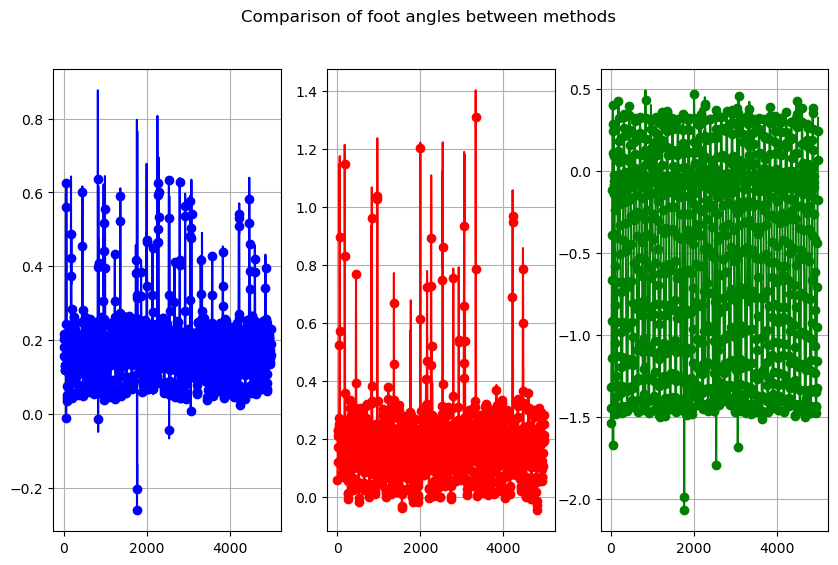

In [31]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
fig.suptitle('Comparison of foot angles between methods')
axs[0].plot(angle_R_foot[:,0], 'b', label='Python')
axs[0].plot(tn[0::5],angf_matlab[0::5,0], 'bo', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_R_foot[:,1], 'r', label='Python')
axs[1].plot(tn[0::5],angf_matlab[0::5,1], 'ro', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_R_foot[:,2], 'g', label='Python')
axs[2].plot(tn[0::5],angf_matlab[0::5,2], 'go', label='Matlab')
axs[2].grid('on')
plt.show()

In [33]:
# Import Pelvis angles calculated in Matlab
fn_p_matlab = os.path.join(pathname, 'r_pelvis_angle.txt')
angp_matlab = np.loadtxt(fn_p_matlab) * (np.pi/180)

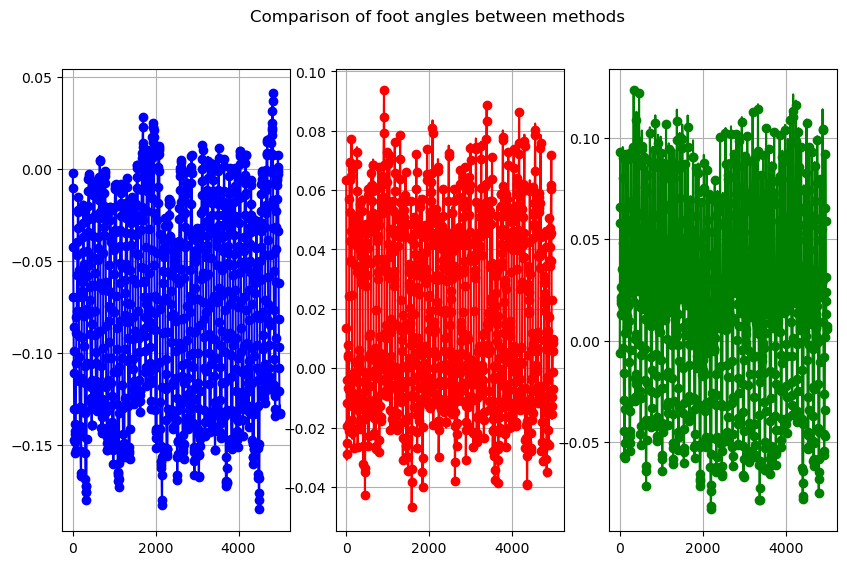

In [34]:
fig, axs = plt.subplots(1,3, figsize=(10,6))
fig.suptitle('Comparison of foot angles between methods')
axs[0].plot(angle_Pelvis[:,0], 'b', label='Python')
axs[0].plot(tn[0::5],angp_matlab[0::5,0], 'bo', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_Pelvis[:,1], 'r', label='Python')
axs[1].plot(tn[0::5],angp_matlab[0::5,1], 'ro', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_Pelvis[:,2], 'g', label='Python')
axs[2].plot(tn[0::5],angp_matlab[0::5,2], 'go', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
# Import ankle angles calculated in Matlab
fn_a_matlab = os.path.join(pathname, 'r_ankle_angle_R.txt')
anga_matlab = np.loadtxt(fn_a_matlab)
anga_matlab = anga_matlab

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of ankle angles between methods')
axs[0].plot(angle_R_ankle[:,0], 'b', label='Python')
axs[0].plot(tn[0::5],anga_matlab[0::5,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_R_ankle[:,1], 'r', label='Python')
axs[1].plot(tn[0::5],anga_matlab[0::5,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_R_ankle[:,2], 'g', label='Python')
axs[2].plot(tn[0::5],anga_matlab[0::5,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
# Import ankle angles calculated in Matlab
fn_k_matlab = os.path.join(pathname, 'r_knee_angle_R.txt')
angk_matlab = np.loadtxt(fn_k_matlab)
angk_matlab = angk_matlab

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of knee angles between methods')
axs[0].plot(angle_R_knee[:,0], 'b', label='Python')
axs[0].plot(tn[0::5],angk_matlab[0::5,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_R_knee[:,1], 'r', label='Python')
axs[1].plot(tn[0::5],angk_matlab[0::5,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_R_knee[:,2], 'g', label='Python')
axs[2].plot(tn[0::5],angk_matlab[0::5,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
# Import ankle angles calculated in Matlab
fn_h_matlab = os.path.join(pathname, 'r_hip_angle_R.txt')
angh_matlab = np.loadtxt(fn_h_matlab)
angh_matlab = angh_matlab

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of knee angles between methods')
axs[0].plot(tn,angle_R_hip[:,0], 'b', label='Python')
axs[0].plot(tn[0::5],angh_matlab[0::5,0], 'bo', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_R_hip[:,1], 'r', label='Python')
axs[1].plot(tn[0::5],angh_matlab[0::5,1], 'ro', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_R_hip[:,2], 'g', label='Python')
axs[2].plot(tn[0::5],angh_matlab[0::5,2], 'go', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
# Import ankle angles calculated with notebook
fn_ankle = os.path.join(data_dir, 'ankle_ang.csv')
df_ankle = pd.read_csv(fn_ankle, delimiter='\t')

In [ ]:
ang_ank2 = df_ankle.values

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of ankle angles between methods')
axs[0].plot(angle_R_ankle[:,0], 'g', label='Sean')
axs[0].plot(ang_ank2[:,0], 'g*', label='Regi')
axs[1].plot(angle_R_ankle[:,1], 'g', label='Sean')
axs[1].plot(ang_ank2[:,1], 'g*', label='Regi')
axs[2].plot(angle_R_ankle[:,2], 'g', label='Sean')
axs[2].plot(ang_ank2[:,2], 'g*', label='Regi')
#axs.grid('on')
fig.legend()
plt.show()